# Урок 8. Снижение размерности данных

1. Можно ли отобрать наиболее значимые признаки с помощью PCA?

Да, конечно можно - на основе максимальных собственных значений 
(d  значений, меньших чем первоначальное количество признаков) создаем соответствующие им собственные вектора, из них
формируем матрицу весов и получаем новые признаки
$$Z=XW.$$


PCA наиболее хорошо работает, когда собственные значения $\lambda$ на каком-то участке графика распределения убывают скачкообразно (критерий крутого склона)

2*. Примите участие в одном или двух соревнованиях и пришлите

свой псевдоним на Kaggle и ссылку на github с решением соревнования

по регрессии (https://www.kaggle.com/c/tutors-expected-math-exam-results)

или классификации (https://www.kaggle.com/c/choose-tutors). 
В скрипте можно использовать только эти импорты:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 

2 задание сделано в отдельном файле, названном Ukladnikov_Andrey_CourseProject_Regression.ipynb

3*. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()
Используем формулу U, eig_values, eig_vectors = np.linalg.svd(covariance_matrix) вместо eig_values, eig_vectors = np.linalg.eig(covariance_matrix) для получения собственных значений и векторов (здесь она закоментарена)

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import model_selection

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [4]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_.T.dot(X_)

# Используем формулу сингулярного разложения с использованием функции numpy.linalg.svd()
#U, eig_values, eig_vectors = np.linalg.svd(covariance_matrix)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

#print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

437.7746724797988
137.10457072021055
22.013531335697195
3.107225464292886


In [5]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[72.96244541329987, 22.850761786701778, 3.6689218892828697, 0.5178709107154814]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [6]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [7]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_.dot(W)

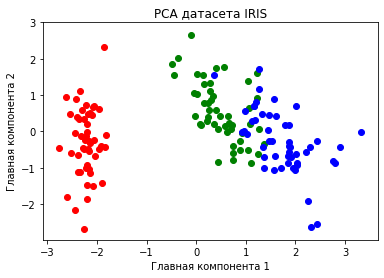

In [8]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

4*. Обучить любую модель классификации на датасете iris до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
X, y = datasets.load_iris(return_X_y=True)

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [12]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [13]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [14]:
N = 50

models = adaboost(X_train, y_train, N)

In [15]:
def predict(X, models):
    
    n_classes = 3
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    print(y_pred.shape)
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        
        
        y_pred[range(n_objects), prediction] += alpha
        print(y_pred)
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

(112, 3)
[[0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 

In [16]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

(38, 3)
[[0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [0.        0.3532851 0.       ]
 [0.3532851 0.        0.       ]
 [

Алгоритм с уменьшением признаков с 4 до 2

In [17]:
Z_train, Z_test, y_train, y_test = model_selection.train_test_split(Z, y, test_size=0.25)

In [18]:
N = 50

models = adaboost(Z_train, y_train, N)

In [19]:
print(f'Точность алгоритма на тестовой выборке с уменьшением признаков с 4 до 2: {(1 - get_error(predict(Z_test, models), y_test)) * 100:.3f}')

(38, 3)
[[0.33323947 0.         0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.33323947 0.         0.        ]
 [0.33323947 0.         0.        ]
 [0.         0.33323947 0.        ]
 [0.33323947 0.         0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.33323947 0.         0.        ]
 [0.33323947 0.         0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.33323947 0.         0.        ]
 [0.         0.33323947 0.        ]
 [0.33323947 0.         0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.         0.33323947 0.        ]
 [0.33323947 0.     

Вывод - точность падает на очень малую величину - точность 92.105 вполне приемлема.